In [2]:
from torchvision import models
import torch
import matplotlib.pyplot as plt
from explanations import multi_cam
from utils import load_image, apply_transforms, apply_crop_resize
import copy
import numpy as np
import cv2
import glob

## Initialise model and Multi-CAM

In [3]:
model_name = 'resnet50'

if model_name == 'resnet50':
    image_size = 224
    model_blocks = 7
    model = models.resnet50(pretrained=True)
    
elif model_name == 'densenet':
    image_size = 224
    model_blocks = 7
    model = models.densenet121(pretrained=True)
    
elif model_name == 'inception':
    image_size = 299
    model_blocks = 8
    model = models.inception_v3(pretrained=True)
    
model.eval()
if torch.cuda.is_available():
    model.cuda()
    
new_size = model_blocks * 2 

# init multi-cam 
cam = multi_cam.MultiCam(copy.deepcopy(model), model_name, output_size=(image_size, image_size))
# set multi-cam size, if size is equal to model_blocks it gives the original Grad-CAM explanation
cam.set_new_size(new_size=new_size)

In [4]:
# Function to load explain a single image
def explain_image(image_path):
    
    orig_image = load_image(image_path)
    image_to_show = np.array(apply_crop_resize(orig_image))
    input_image = apply_transforms(orig_image)
    if torch.cuda.is_available():
        input_image = input_image.cuda()
    target_class = torch.argmax(model(input_image))

    pixel_scores = cam(input_image, target_class)

    heatmap = (pixel_scores - np.min(pixel_scores)) / (np.max(pixel_scores) - np.min(pixel_scores))
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    return image_to_show, heatmap
    

## Explain each example image using Multi-CAM

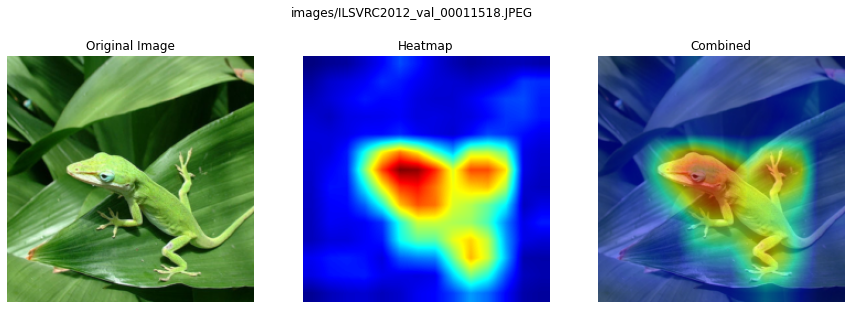

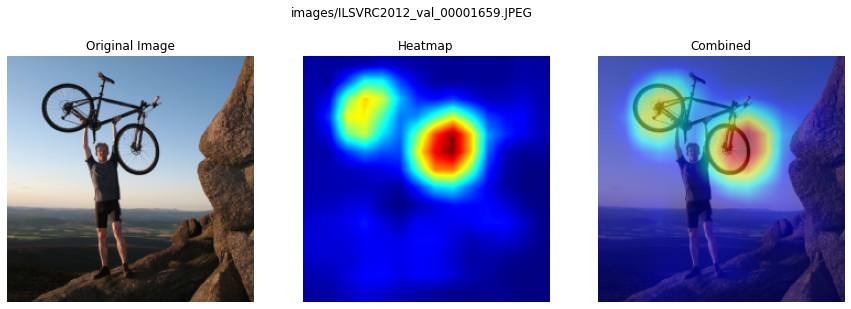

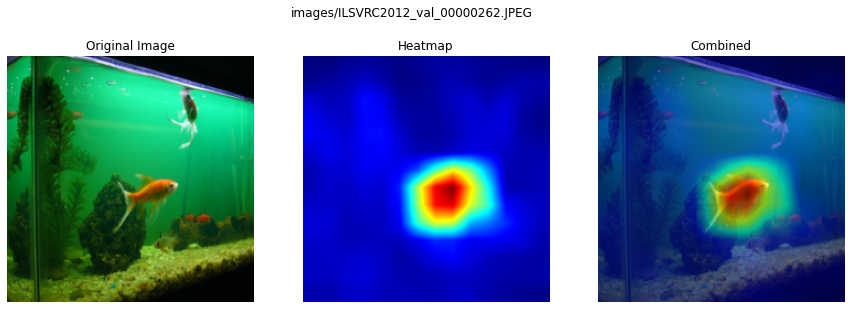

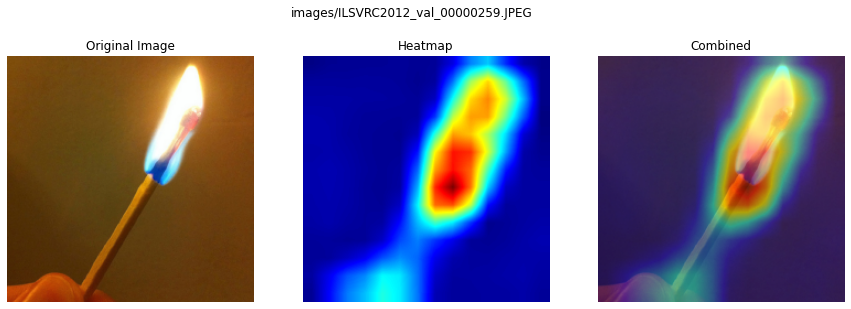

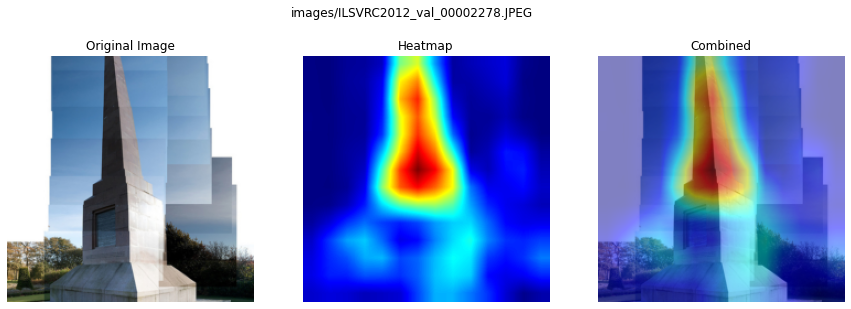

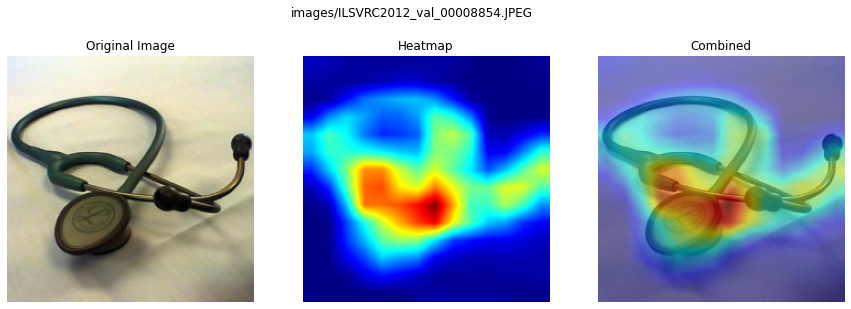

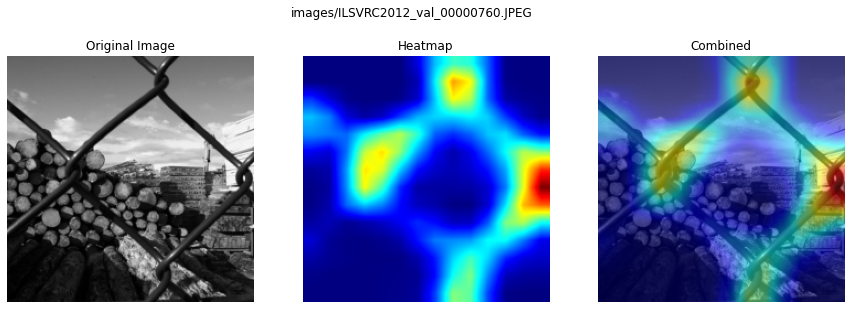

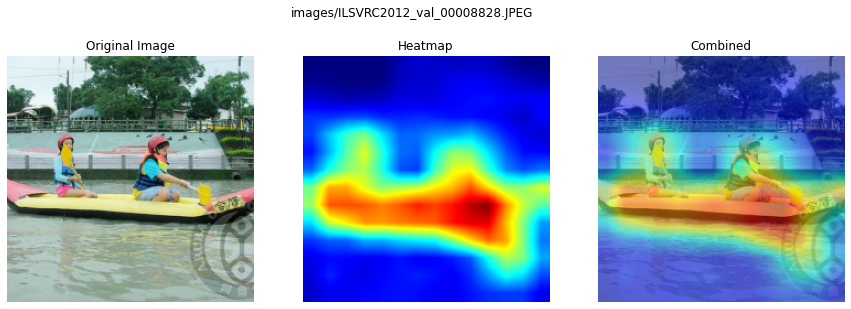

In [5]:
image_paths = glob.glob('images/*.JPEG')
for im_path in image_paths:
    image_to_show, heatmap = explain_image(im_path)

    plt.figure(figsize = (15,5))
    plt.suptitle(im_path)
    plt.subplot(1,3,1)
    plt.title('Original Image')
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title('Heatmap')
    plt.imshow(heatmap)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title('Combined')
    plt.imshow(cv2.addWeighted(image_to_show, 0.5, heatmap, 0.5, 0.0))
    plt.axis('off')
    
    plt.show()


## Explore effect of CAM sizes

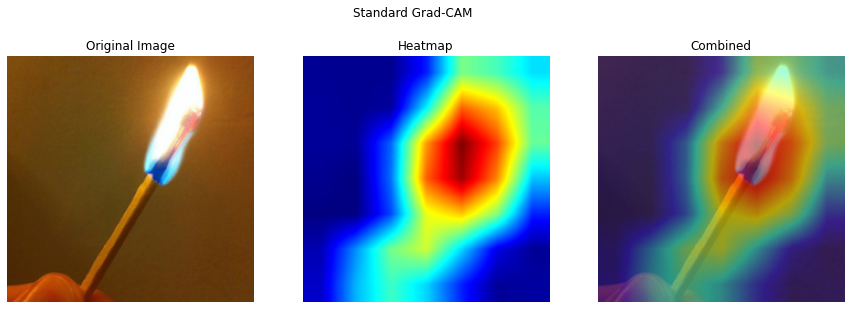

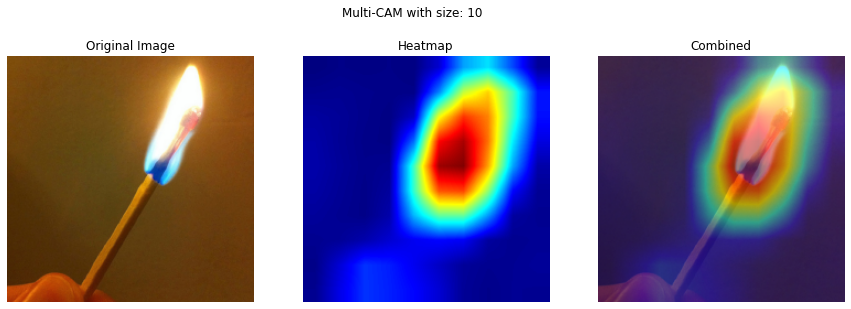

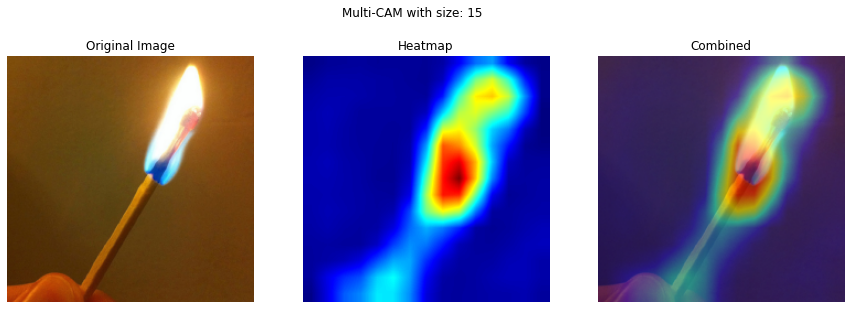

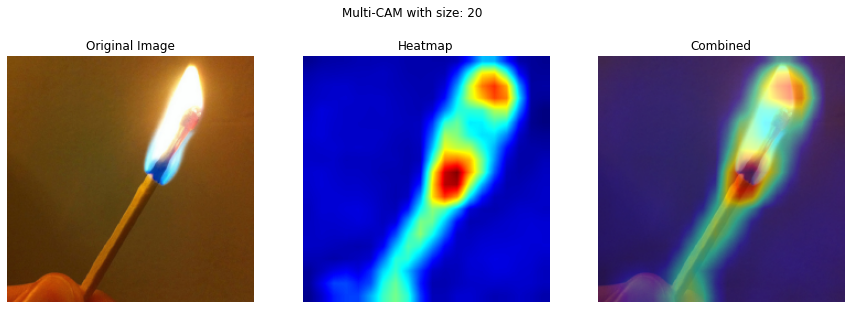

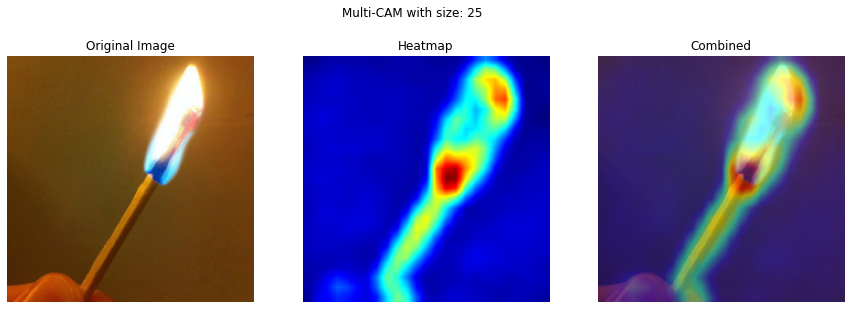

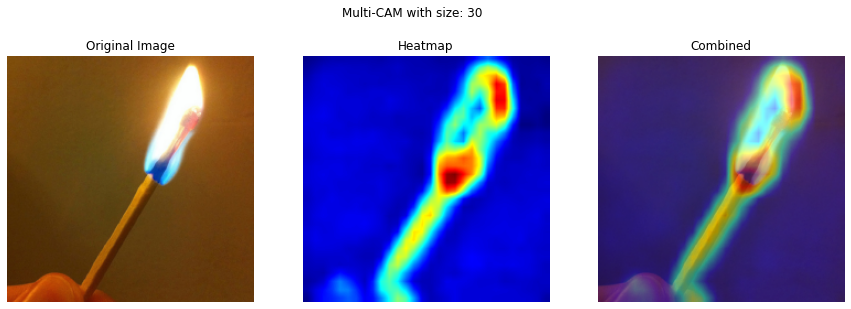

In [6]:
for new_size in [model_blocks,10,15,20,25,30]:
    
    cam.set_new_size(new_size=new_size)
    image_to_show, heatmap = explain_image('images/ILSVRC2012_val_00000259.JPEG')
    
    plt.figure(figsize = (15,5))   
    plt.subplot(1,3,1)
    plt.title('Original Image')
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title('Heatmap')
    plt.imshow(heatmap)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title('Combined')
    plt.imshow(cv2.addWeighted(image_to_show, 0.5, heatmap, 0.5, 0.0))
    plt.axis('off')
    
    if new_size == model_blocks:
         plt.suptitle('Standard Grad-CAM')
    else:
        plt.suptitle('Multi-CAM with size: ' + str(new_size))
    plt.show()